In [177]:
# import external stuff
import pickle
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import jax
from jax import grad, jit, vmap
from itertools import product

In [178]:
# import internal stuff
from src.data import create_reg_data_TI_onehot_eval, create_reg_data
from src.config import config
from src.train import *

# verify that lin regress solves the problem for the eval dataset

In [179]:
eval_rng = jax.random.key(42)

In [180]:
seq, target, w, true_order = create_reg_data_TI_onehot_eval(eval_rng,
                               input_size,
                               dataset_size,
                               size_distract,
                               input_range,
                               weight_scale,
                               (i, j),
                               return_true_order=True)



In [181]:
Ys

Array([ 1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.],      dtype=float32)

In [182]:
reg.predict(seq[:-1, :-1])

array([ 3.9999995 , -3.9999995 ,  1.0000005 , -0.99999917,  2.        ,
        6.0000005 , -1.9999996 ,  2.000001  , -4.0000005 ,  4.        ,
       -2.0000005 , -6.000001  ], dtype=float32)

In [183]:
seq[:-1, -1]

Array([-1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.],      dtype=float32)

In [184]:
lm = linear_model.LinearRegression()
reg = lm.fit(seq[:-1, :-1], seq[:-1, -1])
np.round(reg.coef_)

array([ 3.,  1., -1.,  2., -0., -3., -2., -3., -1.,  1., -2.,  0.,  3.,
        2.], dtype=float32)

In [185]:
X_query = jnp.array([0, 0, 1, 1, 0, 0])
reg.predict(X_query.reshape(1,-1))

ValueError: X has 6 features, but LinearRegression is expecting 14 features as input.

In [186]:
input_size = 14
n_items = input_size//2
dataset_size = (input_size//2-1)*2 
size_distract = 0
input_range = 1
weight_scale = 1

pred_mat_lm = np.zeros((n_items, n_items))


for i, j in product(range(n_items), range(n_items)):
    seq, target, w, true_order = create_reg_data_TI_onehot_eval(eval_rng,
                               input_size,
                               dataset_size,
                               size_distract,
                               input_range,
                               weight_scale,
                               (i, j),
                               return_true_order=True)
    Xs = seq[:-1, :-1]
    Ys = seq[:-1, -1]
    
    X_query = seq[-1, :-1]
    
    lm = linear_model.LinearRegression()
    reg = lm.fit(Xs, Ys)

    pred = reg.predict(X_query.reshape(1, -1)).item()
    pred_mat_lm[i, j] = pred * (-1)  # for some reason the authors do a sign inversion 

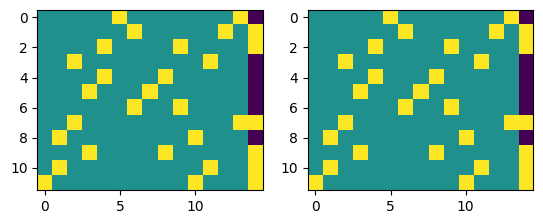

In [187]:
seq1, target, w, true_order = create_reg_data_TI_onehot_eval(eval_rng,
                           input_size,
                           dataset_size,
                           size_distract,
                           input_range,
                           weight_scale,
                           (0, 1),
                           return_true_order=True)

seq2, target, w, true_order = create_reg_data_TI_onehot_eval(eval_rng,
                           input_size,
                           dataset_size,
                           size_distract,
                           input_range,
                           weight_scale,
                           (1, 1),
                           return_true_order=True)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(seq1[:-1])
ax[1].imshow(seq2[:-1])

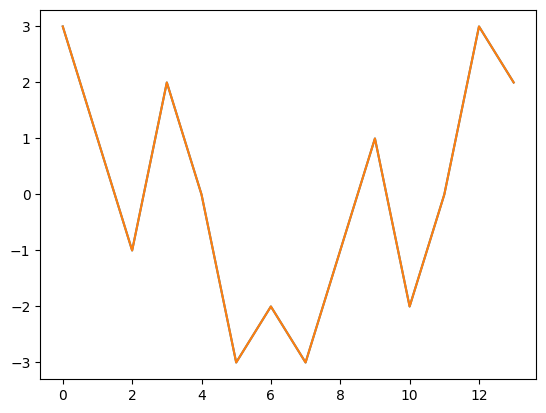

In [188]:
plt.plot(w, label='True weights')
plt.plot(reg.coef_, label='Fitted weights')

In [189]:
reg.predict(X_query.reshape(1, -1)).item()

1.2914335911773378e-07

Text(0.5, 1.0, 'True order: [5 6 2 4 1 3 0]')

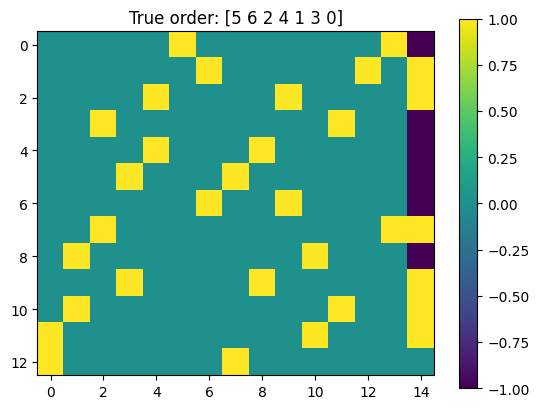

In [190]:
plt.imshow(seq);plt.colorbar()
plt.title(f'True order: {true_order}')

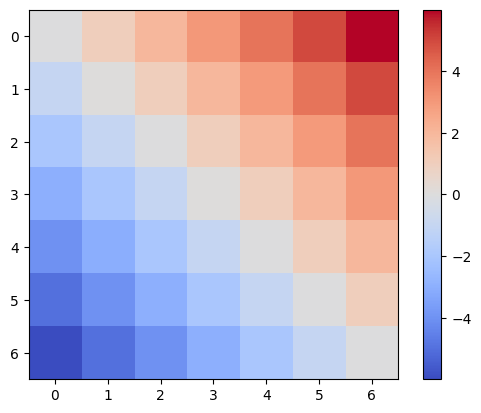

In [191]:
plt.imshow(pred_mat_lm, cmap='coolwarm'); plt.colorbar()

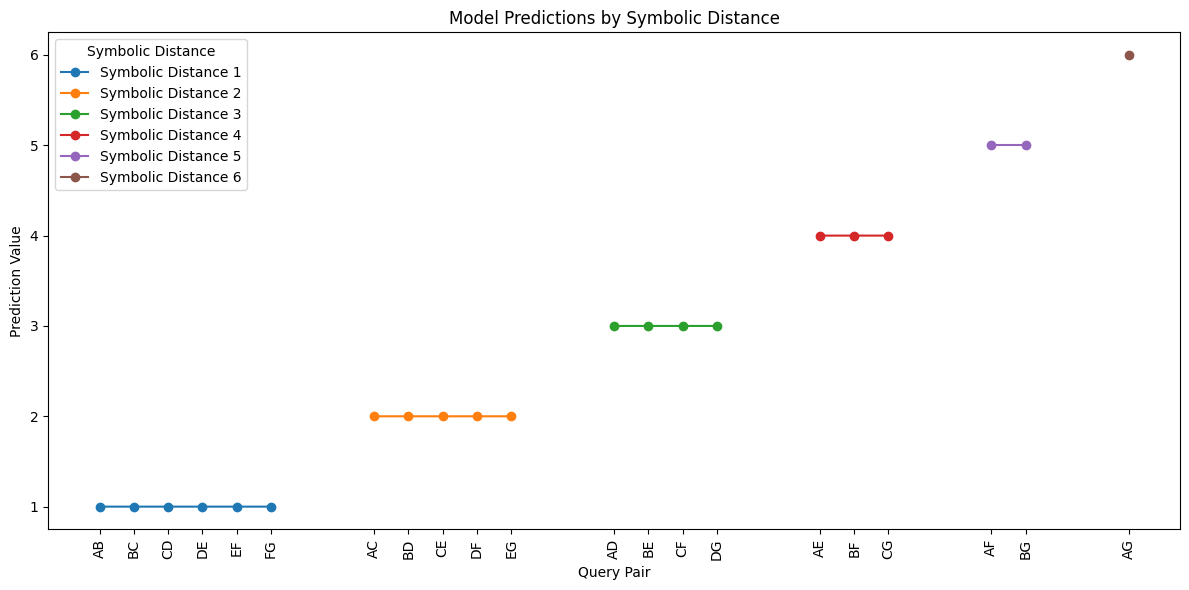

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Generate a random NxN matrix to simulate `predict_mat`
N = n_items
# predict_mat = np.random.random((N, N))

# Helper function to generate query labels
def get_query_label(i, j):
    return chr(65 + i) + chr(65 + j)  # Convert indices to characters (A, B, C, ...)

# Create a dictionary to store predictions grouped by symbolic distance
distances = {}

# Loop through the upper triangular matrix excluding diagonal (symbolic distance 0)
for i in range(N):
    for j in range(i + 1, N):  # Upper triangle, excluding the diagonal
        dist = j - i  # Symbolic distance
        if dist > 0:  # Ignore symbolic distance 0
            query_label = get_query_label(i, j)  # Get query label
            prediction = pred_mat_lm[i, j]  # Get prediction value
            
            # Store prediction in the dictionary, grouped by symbolic distance
            if dist not in distances:
                distances[dist] = {'labels': [], 'predictions': []}
            distances[dist]['labels'].append(query_label)
            distances[dist]['predictions'].append(prediction)

# Create a figure
plt.figure(figsize=(12, 6))

# Initialize a list to hold the x positions for the discontinuous axis
x_positions = []
x_ticks = []

# Variable to manage spacing between groups
current_x_pos = 0

# Plot separate lines for each symbolic distance
for dist in sorted(distances.keys()):
    labels = distances[dist]['labels']
    predictions = distances[dist]['predictions']
    
    # Create a range of x positions for the current symbolic distance
    x_pos = np.arange(current_x_pos, current_x_pos + len(labels))
    x_positions.append(x_pos)
    x_ticks.extend(x_pos)  # Collect the positions for x-ticks
    
    # Plot the line for the current symbolic distance
    plt.plot(x_pos, predictions, marker='o', label=f'Symbolic Distance {dist}')
    
    # Update the x position for the next group (to create a gap)
    current_x_pos += len(labels) + 2  # Add a gap of 2 to create space between groups

# Customize the plot
plt.title('Model Predictions by Symbolic Distance')
plt.xlabel('Query Pair')
plt.ylabel('Prediction Value')

# Set the x-ticks to be the center of each group of query pairs
plt.xticks(x_ticks, np.concatenate([distances[dist]['labels'] for dist in sorted(distances.keys())]), rotation=90)

# Add a legend and grid
plt.legend(title='Symbolic Distance')
plt.grid(False)

# Tight layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [193]:
true_order

Array([5, 6, 2, 4, 1, 3, 0], dtype=int32)

# eval transformer on TI paradigm 

In [194]:
#@title Config
softmax = False #@param {type:"boolean"}
layernorm = False #@param {type:"boolean"}

recurrent_Transformer = False #@param {type:"boolean"}
num_layers = 4 #@param {type:"integer"}
num_heads = 1 #@param {type:"integer"}
num_seeds = 1 #@param {type:"integer"}

config.seed = 0
config.local_usage = True

####
config.deq = recurrent_Transformer
config.gd_deq = recurrent_Transformer 
config.att_only_trans = True
####

config.pre_train_gd = False
config.train_gd_whitening = False
config.train_gd_lr = False
config.use_bias = False
config.include_query = False

config.distract_size = 0
config.training_steps = 5000 if config.deq else 50000
config.training_steps_gd = 1000 if config.gd_deq else 30000
config.use_softmax = softmax
config.first_layer_sm = False
config.use_non_lin_mix = False

config.widening_factor = 4

config.layer_norm = layernorm
config.out_proj = False
config.in_proj = False
config.adam = True

i_size = 14  # 7 classes
c_size = (i_size//2-1) * 2 - 1  # -1 because we leave one adjacent pair out, which the model should be trained on with linear regression

config.dataset_size = c_size
config.input_size = i_size
config.key_size = i_size + 1

config.num_layers = num_layers
config.num_heads = num_heads

config.grad_clip_value = 10 if num_layers > 2 else 0.001
config.grad_clip_value_gd = 10 if num_layers > 2 else 0.001
config.lr = 0.0005 if num_layers > 3 else 0.001
config.gd_lr = 0.0005 if num_layers > 3 else 0.001
config.wd = 0.0
config.init_scale = 0.002 / config.num_layers
config.bs = 2048
config.bs_gd_train = 512
config.dampening = 1.0
config.clip = 10 if num_layers > 3 else 0 

config.dropout_rate = 0.0
data_creator = vmap(create_reg_data,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)

config.y_update = False
config.input_range = 1

config.pos_enc = False
config.pos_enc_size = 20
config.concat_pos_enc = False
config.analyse = True

config.cycle_data = 0 #0 means online learning
config.num_seeds = num_seeds
if config.num_layers == 1:
  assert config.deq == True
  assert config.gd_deq == True

if config.num_layers > 1:
  assert config.y_update == False

config.in_proj = False
config.emb_size = 11

In [195]:

seq, target, w = create_reg_data_TI_onehot_eval(eval_rng, 
                                                config.input_size, 
                                                config.dataset_size, 
                                                config.size_distract, 
                                                config.input_range, 
                                                1, (6, 1))

In [196]:
# load params from data
param_fn = 'model_params_2024-11-14 13:46:51.038983.pkl'
param_fn_first = 'model_params_2024-11-13 13:14:17.103829.pkl'

with open(param_fn_first, 'rb') as f:
    loaded_params = pickle.load(f)


In [197]:
# single prediction (might want to do multiple random seeds later)
predict_mat = np.zeros((n_items, n_items))

eval_rng, eval_rng2 = jax.random.split(eval_rng, 2)

for i, j in product(range(n_items), range(n_items)):
    seq, target, w = create_reg_data_TI_onehot_eval(eval_rng,
                           config.input_size,
                           config.dataset_size,
                           config.size_distract,
                           config.input_range,
                           config.weight_scale,
                           (i, j))
    preds = predict.apply(loaded_params, eval_rng, jnp.expand_dims(seq,0), False)
    predict_mat[i, j] = preds[0, -1, -1]    


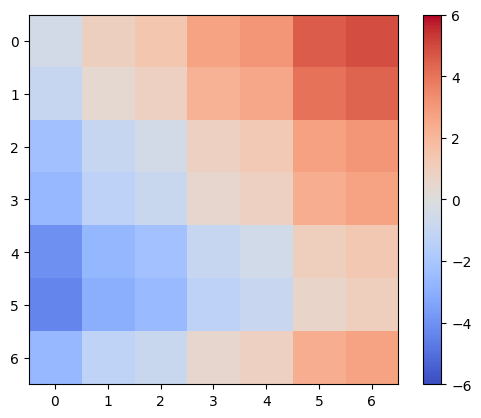

In [198]:
plt.imshow(predict_mat, cmap='coolwarm', vmin=-(n_items-1), vmax=n_items-1)
plt.colorbar()